In [381]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [393]:
  # Set the desired chunk size
dfs = pd.read_csv('train.csv', chunksize=500000, index_col = 'Unnamed: 0')
dfs

In [394]:
for chunks in dfs:
    print(chunks.shape)

(500000, 3)
(500000, 3)
(500000, 3)
(500000, 3)
(500000, 3)
(500000, 3)
(220868, 3)


In [395]:
chunks

,Patient-Uid,Date,Incident
24563447,a0eedf3b-1c7c-11ec-8023-16262ee38c7f,2019-12-31,DRUG_TYPE_3
24563485,a0ef09b2-1c7c-11ec-83b0-16262ee38c7f,2018-04-06,DRUG_TYPE_6
24563487,a0f03d46-1c7c-11ec-8dac-16262ee38c7f,2017-11-24,DRUG_TYPE_7
24563492,a0eeaffe-1c7c-11ec-abd7-16262ee38c7f,2019-05-21,DRUG_TYPE_3
24563497,a0f02f80-1c7c-11ec-bde4-16262ee38c7f,2016-11-21,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [397]:
# Assuming you have a DataFrame named 'df' with a column named 'Incident'
frequency_dist = chunks['Incident'].value_counts()
print(frequency_dist)

DRUG_TYPE_6     45618
DRUG_TYPE_1     38328
DRUG_TYPE_2     34363
DRUG_TYPE_7     27056
DRUG_TYPE_0     23043
DRUG_TYPE_3     16444
DRUG_TYPE_8      9233
TARGET DRUG      9224
DRUG_TYPE_9      7482
DRUG_TYPE_5      3567
DRUG_TYPE_10     2853
DRUG_TYPE_13     1509
DRUG_TYPE_12      909
DRUG_TYPE_15      651
DRUG_TYPE_14      238
DRUG_TYPE_16      125
DRUG_TYPE_4       117
TEST_TYPE_1        33
DRUG_TYPE_11       28
DRUG_TYPE_17       22
TEST_TYPE_0        16
TEST_TYPE_3         6
TEST_TYPE_2         3
Name: Incident, dtype: int64


In [398]:
frequency_dist_df = pd.DataFrame(frequency_dist)
frequency_dist_df.columns = ['Frequency']
print(frequency_dist_df)

              Frequency
DRUG_TYPE_6       45618
DRUG_TYPE_1       38328
DRUG_TYPE_2       34363
DRUG_TYPE_7       27056
DRUG_TYPE_0       23043
DRUG_TYPE_3       16444
DRUG_TYPE_8        9233
TARGET DRUG        9224
DRUG_TYPE_9        7482
DRUG_TYPE_5        3567
DRUG_TYPE_10       2853
DRUG_TYPE_13       1509
DRUG_TYPE_12        909
DRUG_TYPE_15        651
DRUG_TYPE_14        238
DRUG_TYPE_16        125
DRUG_TYPE_4         117
TEST_TYPE_1          33
DRUG_TYPE_11         28
DRUG_TYPE_17         22
TEST_TYPE_0          16
TEST_TYPE_3           6
TEST_TYPE_2           3


In [399]:
chunks.duplicated().sum()

462

In [400]:
chunks.Date = pd.to_datetime(chunks.Date)

In [401]:
chunks['target drug'] = np.where(chunks['Incident'].isin(['TARGET DRUG']), 1, 0)

In [402]:
target_drug_data = chunks[chunks['Incident'] == 'TARGET DRUG']
target_drug_data

,Patient-Uid,Date,Incident,target drug
24563527,a0eee24c-1c7c-11ec-901f-16262ee38c7f,2020-05-01,TARGET DRUG,1
24563599,a0eefc18-1c7c-11ec-a3c1-16262ee38c7f,2020-07-14,TARGET DRUG,1
24563801,a0eedbfe-1c7c-11ec-a471-16262ee38c7f,2020-07-09,TARGET DRUG,1
24563846,a0eee36d-1c7c-11ec-9e5e-16262ee38c7f,2019-01-26,TARGET DRUG,1
24564019,a0eeaa54-1c7c-11ec-afeb-16262ee38c7f,2019-09-05,TARGET DRUG,1
...,...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,1
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,1
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,1
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,1


In [403]:
chunks['year'] = chunks['Date'].dt.year
chunks['month'] = chunks['Date'].dt.month
chunks['day'] = chunks['Date'].dt.day
chunks['DayOfWeek'] = chunks['Date'].dt.dayofweek

In [404]:
chunks['Frequency'] = frequency_dist_df
chunks['TimeSinceLastEvent'] = chunks.groupby('Patient-Uid')['Date'].diff().dt.days
chunks['Treatment_Duration'] = (chunks['year'] - chunks['year'].min()) * 12 + chunks['month']
chunks['EventDuration'] = chunks.groupby('Patient-Uid')['Date'].diff().dt.days
chunks['TimeSinceFirstEvent'] = (chunks['Date'] - chunks.groupby('Patient-Uid')['Date'].transform('min')).dt.days

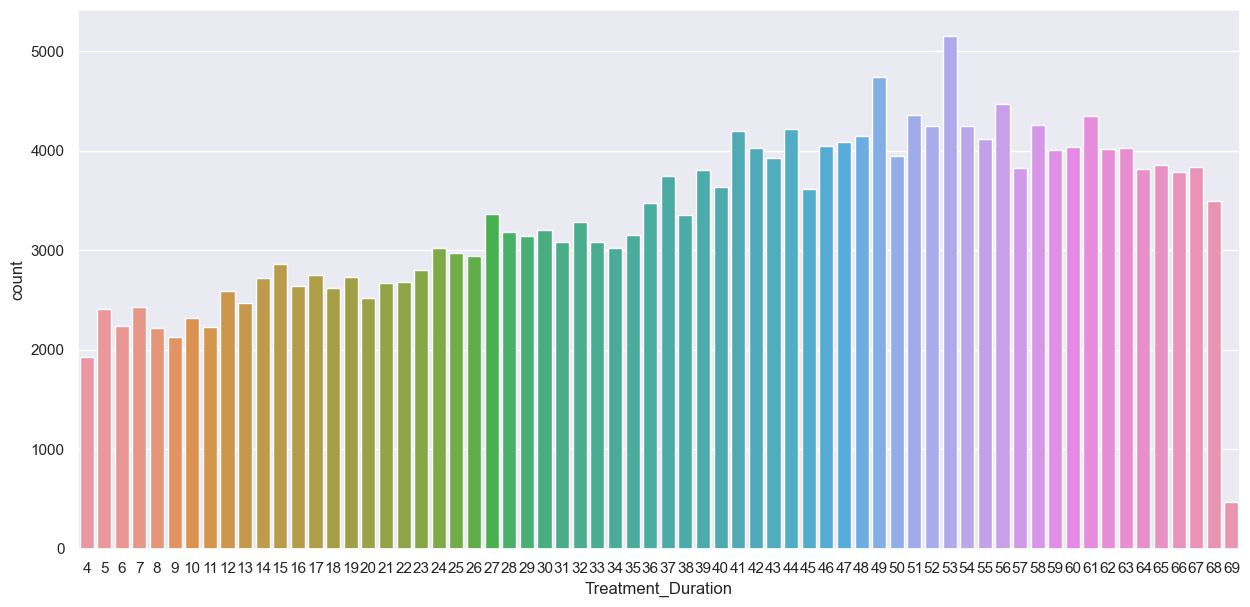

In [405]:
ax = sns.countplot(x = 'Treatment_Duration', data = chunks)

In [406]:
SI = SimpleImputer(strategy = 'constant', missing_values = np.nan)
chunks['TimeSinceLastEvent'] = SI.fit_transform(chunks[['TimeSinceLastEvent']])
chunks['EventDuration'] = SI.fit_transform(chunks[['EventDuration']])
chunks['Frequency'] = SI.fit_transform(chunks[['Frequency']])

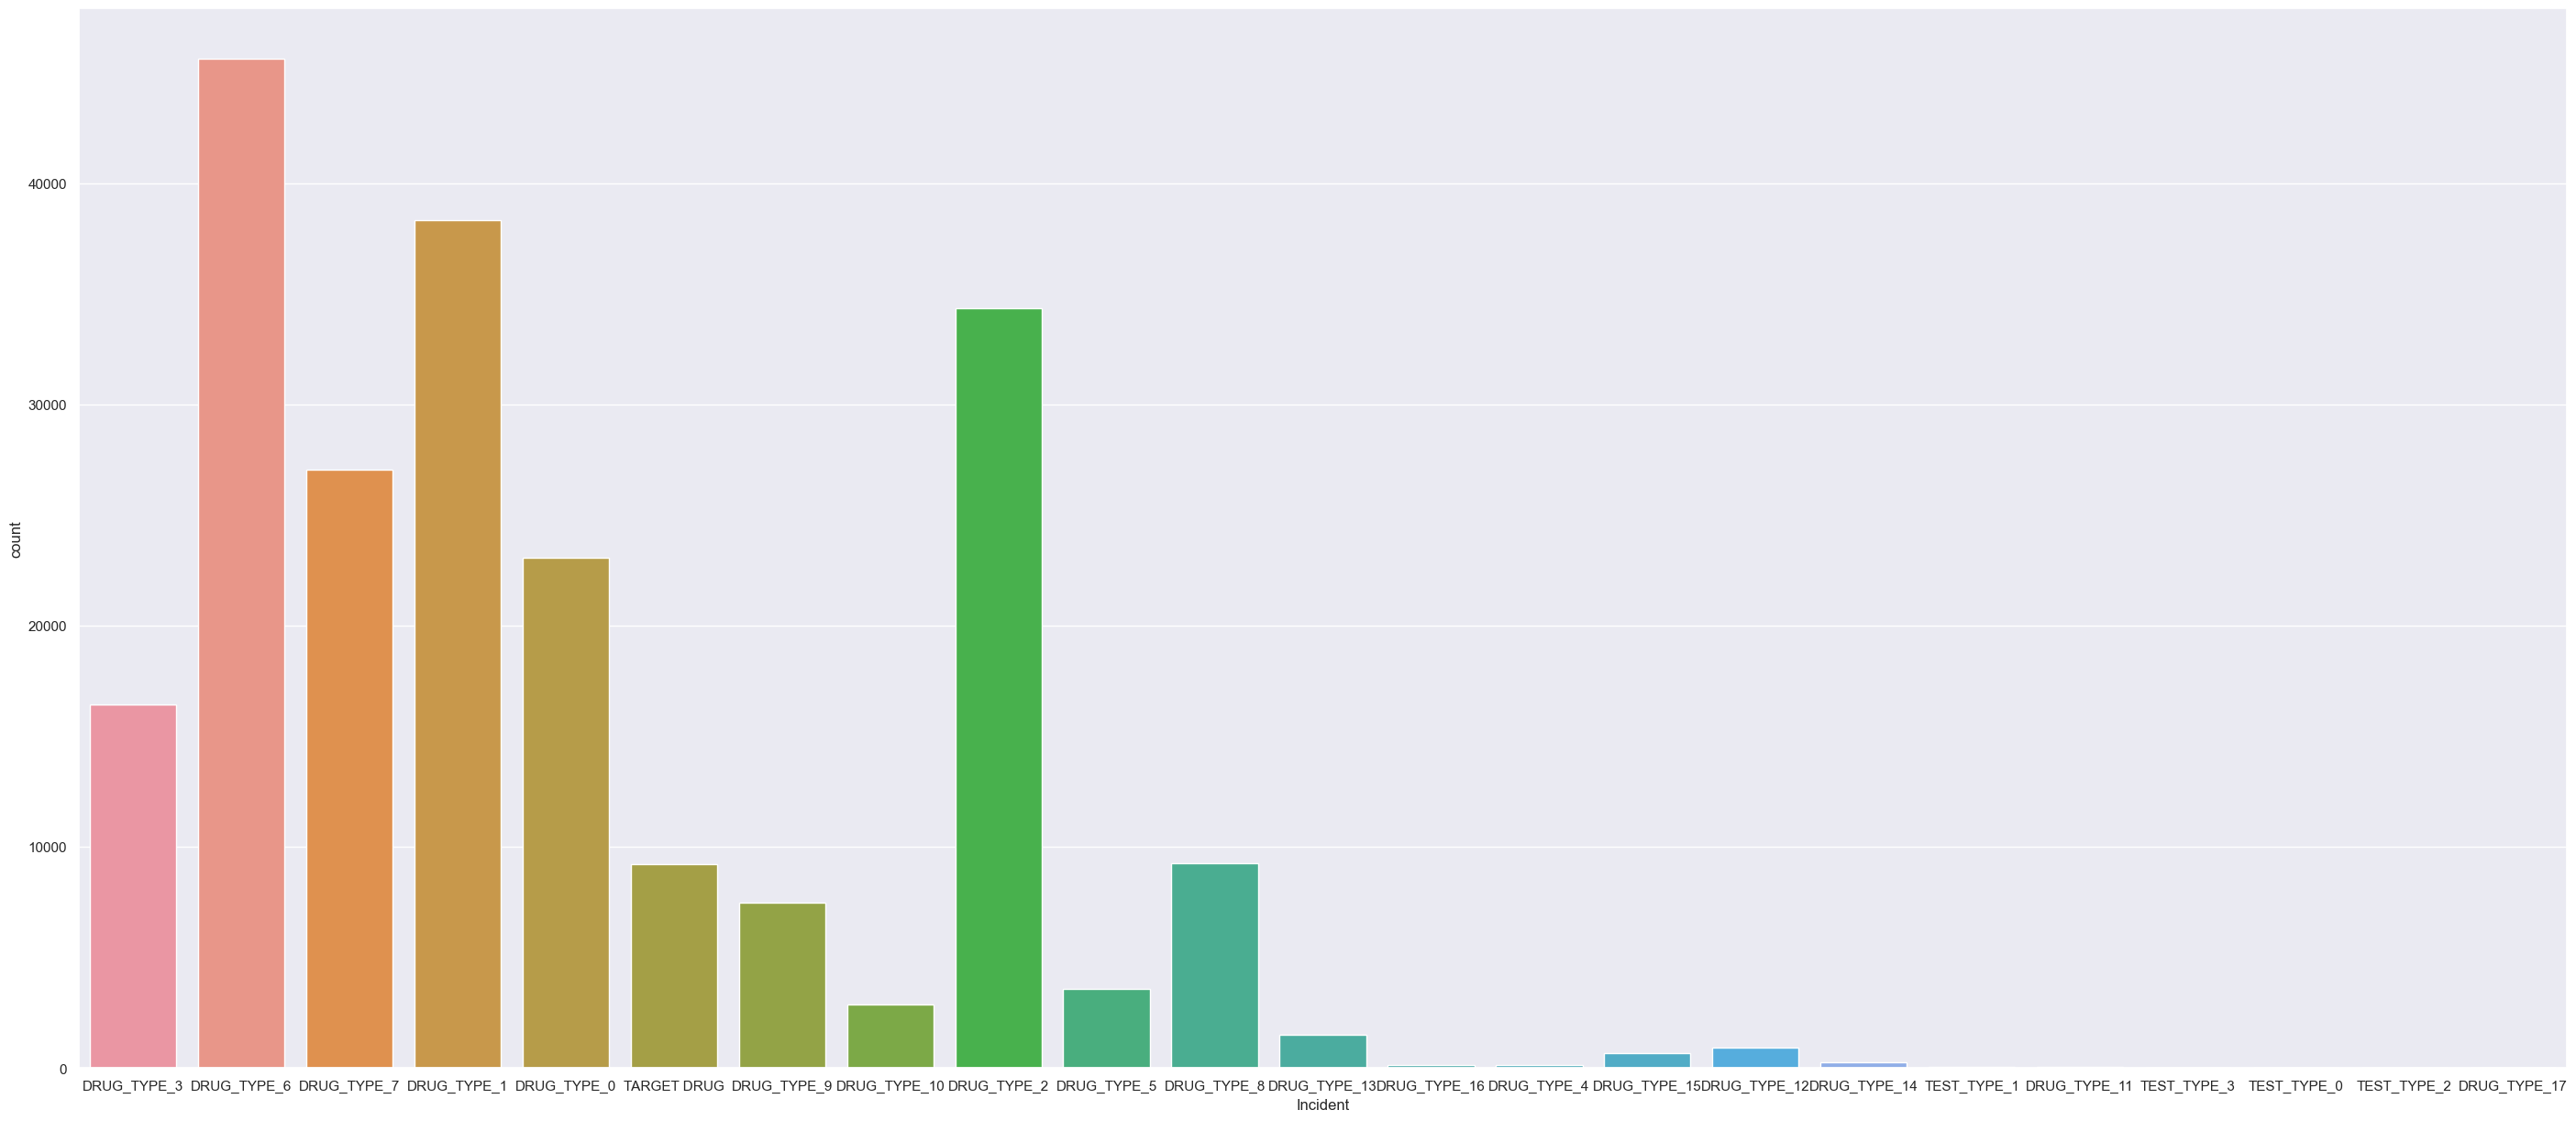

In [407]:
sns.set(rc={'figure.figsize':(35,15)})
ax = sns.countplot(x = 'Incident', data = chunks)

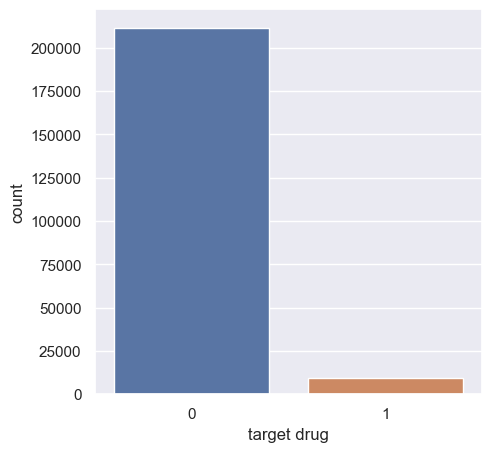

In [408]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.countplot(x = 'target drug', data = chunks)

In [409]:
chunks.Incident.nunique()

23

<AxesSubplot:xlabel='Incident', ylabel='count'>

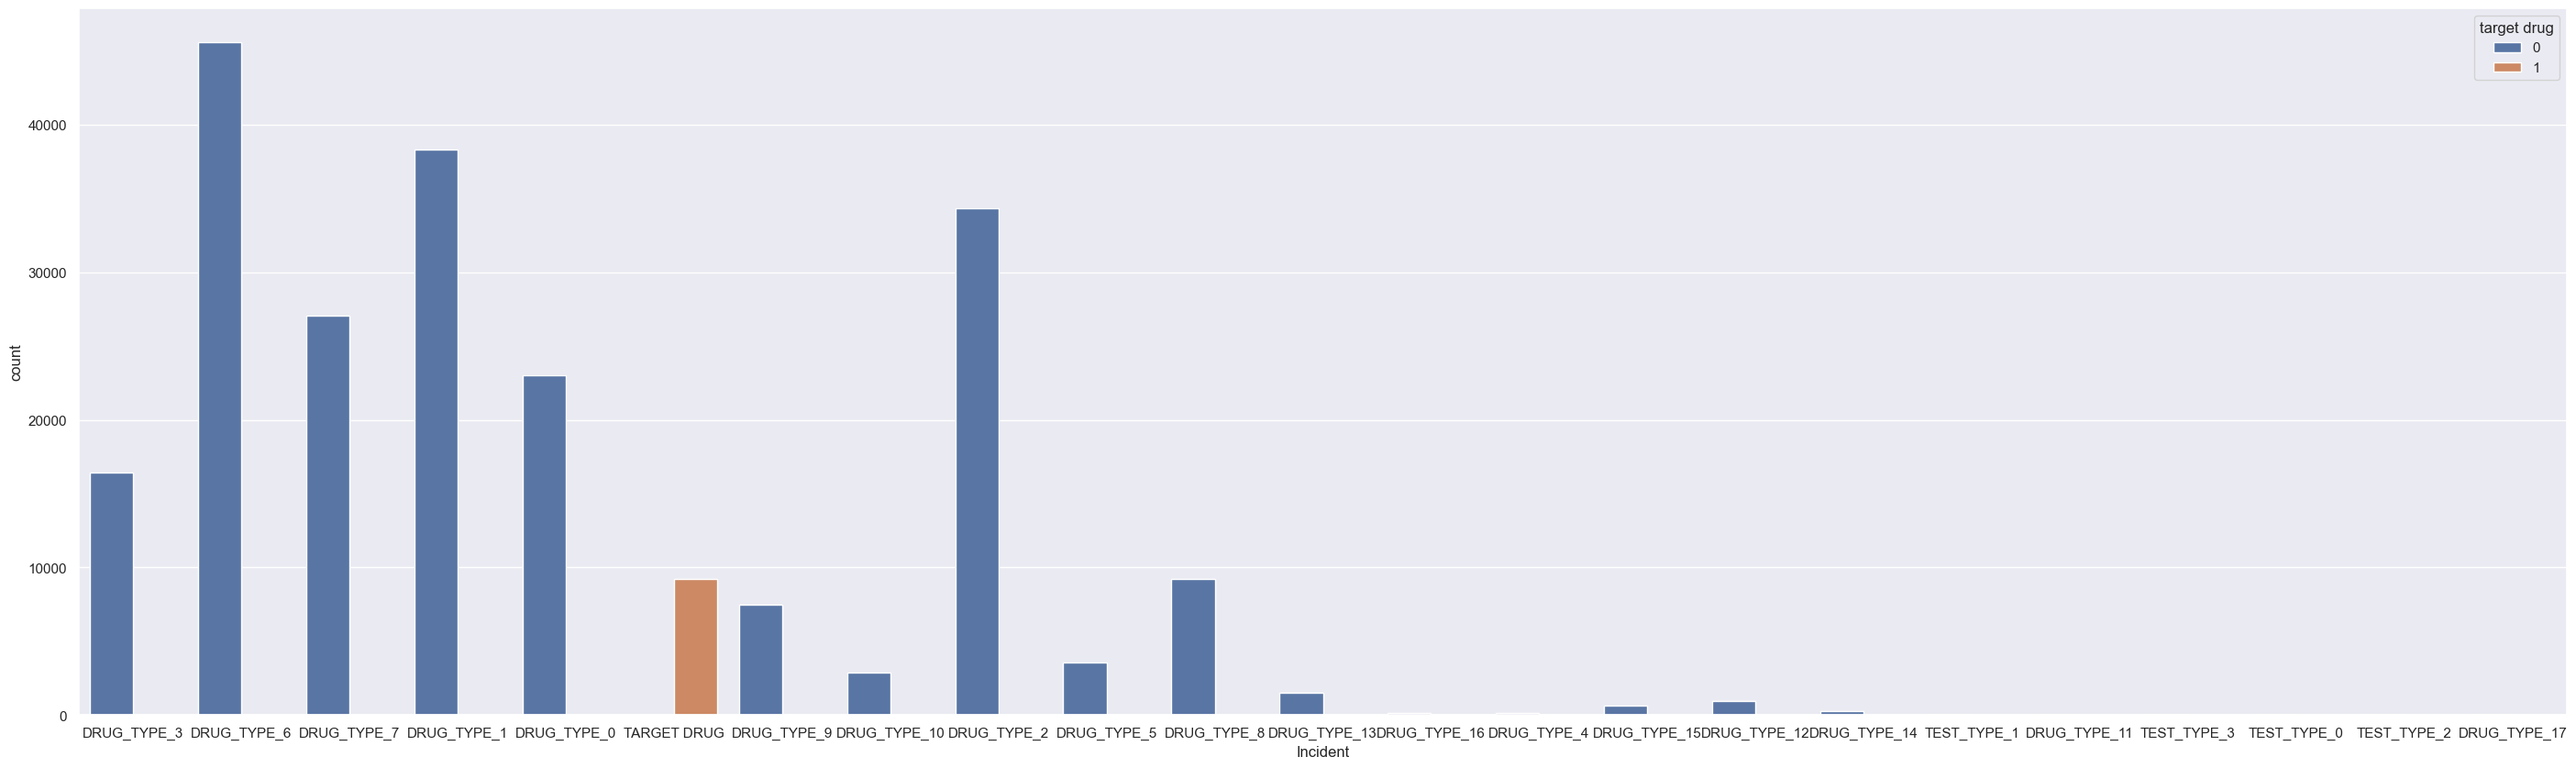

In [410]:
sns.set(rc={'figure.figsize':(35,10)})
sns.countplot(data = chunks, x = 'Incident', hue = 'target drug')

<AxesSubplot:xlabel='target drug', ylabel='count'>

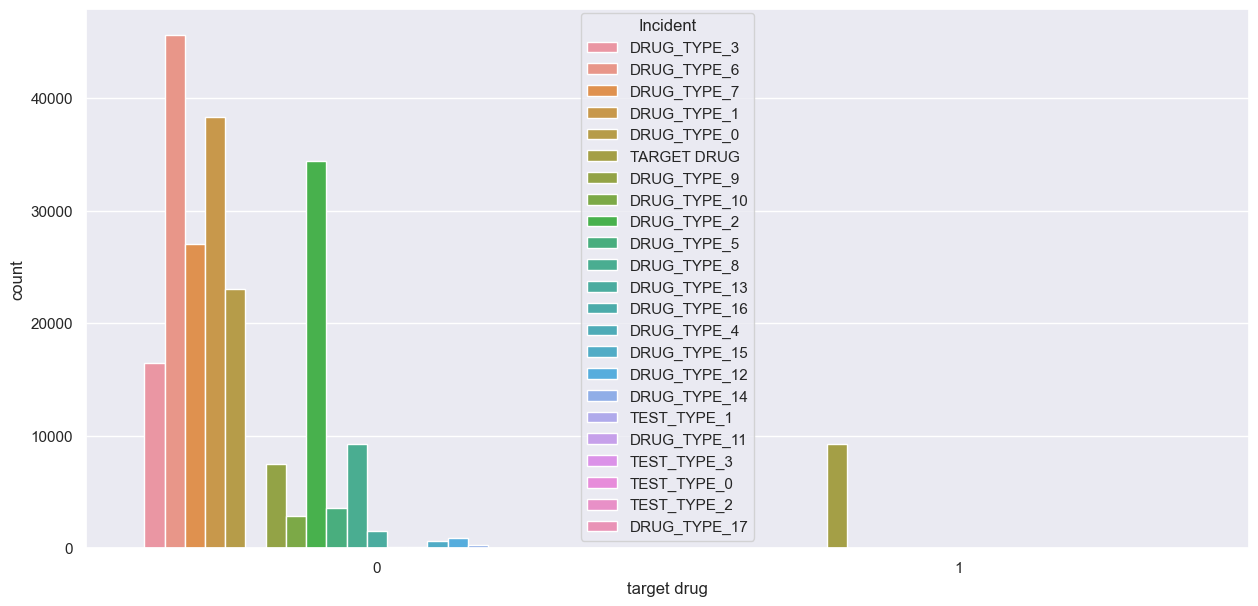

In [411]:
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(data = chunks, x = 'target drug', hue = 'Incident')

<AxesSubplot:xlabel='target drug', ylabel='count'>

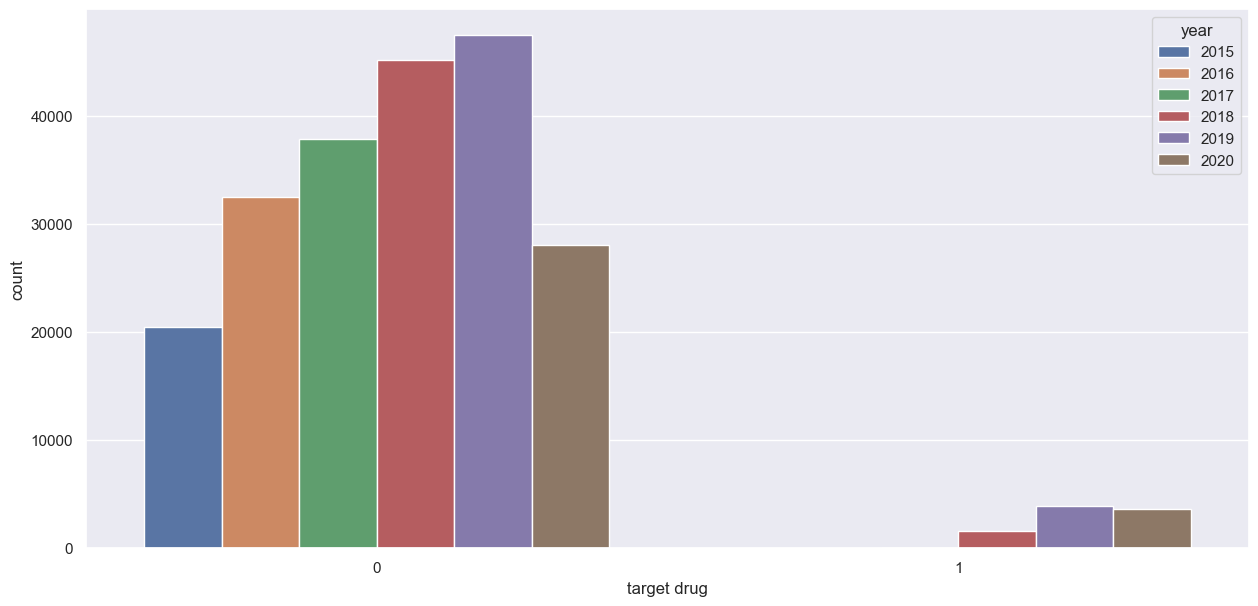

In [412]:
sns.countplot(data = chunks, x = 'target drug', hue = 'year')

In [413]:
chunks = chunks.drop(['Date'], axis=1)

In [414]:
chunks['target drug'].value_counts()

0    211644
1      9224
Name: target drug, dtype: int64

In [415]:
#convert categorical data into numerical
OE = OrdinalEncoder()
chunks['Patient-Uid'] = OE.fit_transform(chunks[['Patient-Uid']])
chunks.Incident = OE.fit_transform(chunks[['Incident']])

In [416]:
chunks

,Patient-Uid,Incident,target drug,year,month,day,DayOfWeek,Frequency,TimeSinceLastEvent,Treatment_Duration,EventDuration,TimeSinceFirstEvent
24563447,6611.0,11.0,0,2019,12,31,1,0.0,0.0,60,0.0,1695
24563485,6829.0,14.0,0,2018,4,6,4,0.0,0.0,40,0.0,904
24563487,8439.0,15.0,0,2017,11,24,4,0.0,0.0,35,0.0,735
24563492,6369.0,11.0,0,2019,5,21,1,0.0,0.0,53,0.0,1396
24563497,8366.0,1.0,0,2016,11,21,0,0.0,0.0,23,0.0,592
...,...,...,...,...,...,...,...,...,...,...,...,...
29080886,6284.0,14.0,0,2018,7,6,4,0.0,944.0,43,944.0,944
29080897,5552.0,14.0,0,2017,12,29,4,0.0,-645.0,36,-645.0,965
29080900,6261.0,2.0,0,2018,10,18,3,0.0,502.0,46,502.0,657
29080903,5593.0,14.0,0,2015,9,18,4,0.0,-1016.0,9,-1016.0,164


<AxesSubplot:>

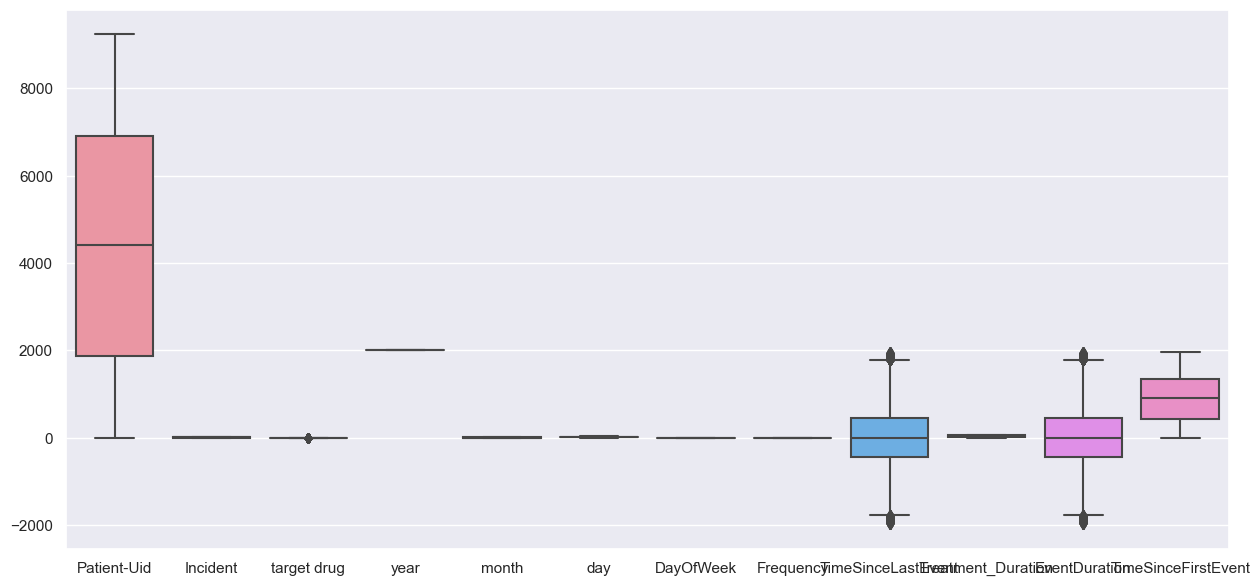

In [417]:
sns.boxplot(data = chunks)

In [418]:
SS = StandardScaler()
SS.fit_transform(chunks)

array([[ 7.97690113e-01,  2.26391743e-01, -2.08764508e-01, ...,
         1.13081067e+00, -2.98986307e-04,  1.45537545e+00],
       [ 8.78637444e-01,  7.13159114e-01, -2.08764508e-01, ...,
         1.80374480e-02, -2.98986307e-04,  1.62747747e-02],
       [ 1.47645947e+00,  8.75414904e-01, -2.08764508e-01, ...,
        -2.60155858e-01, -2.98986307e-04, -2.91194270e-01],
       ...,
       [ 6.67728803e-01, -1.23391037e+00, -2.08764508e-01, ...,
         3.51869416e-01,  7.09451733e-01, -4.33103059e-01],
       [ 4.19688359e-01,  7.13159114e-01, -2.08764508e-01, ...,
        -1.70676105e+00, -1.43676658e+00, -1.33003938e+00],
       [ 4.08177500e-01, -1.39616616e+00, -2.08764508e-01, ...,
         3.51869416e-01, -6.91669707e-01,  8.99740084e-03]])

In [419]:
X = chunks[['Patient-Uid','Incident', 'year', 'month', 'day', 'DayOfWeek','TimeSinceLastEvent','Treatment_Duration','EventDuration','TimeSinceFirstEvent','Frequency']]
y = chunks['target drug']

In [420]:
X

,Patient-Uid,Incident,year,month,day,DayOfWeek,TimeSinceLastEvent,Treatment_Duration,EventDuration,TimeSinceFirstEvent,Frequency
24563447,6611.0,11.0,2019,12,31,1,0.0,60,0.0,1695,0.0
24563485,6829.0,14.0,2018,4,6,4,0.0,40,0.0,904,0.0
24563487,8439.0,15.0,2017,11,24,4,0.0,35,0.0,735,0.0
24563492,6369.0,11.0,2019,5,21,1,0.0,53,0.0,1396,0.0
24563497,8366.0,1.0,2016,11,21,0,0.0,23,0.0,592,0.0
...,...,...,...,...,...,...,...,...,...,...,...
29080886,6284.0,14.0,2018,7,6,4,944.0,43,944.0,944,0.0
29080897,5552.0,14.0,2017,12,29,4,-645.0,36,-645.0,965,0.0
29080900,6261.0,2.0,2018,10,18,3,502.0,46,502.0,657,0.0
29080903,5593.0,14.0,2015,9,18,4,-1016.0,9,-1016.0,164,0.0


In [421]:
y

24563447    0
24563485    0
24563487    0
24563492    0
24563497    0
           ..
29080886    0
29080897    0
29080900    0
29080903    0
29080911    0
Name: target drug, Length: 220868, dtype: int32

In [422]:
chunks

,Patient-Uid,Incident,target drug,year,month,day,DayOfWeek,Frequency,TimeSinceLastEvent,Treatment_Duration,EventDuration,TimeSinceFirstEvent
24563447,6611.0,11.0,0,2019,12,31,1,0.0,0.0,60,0.0,1695
24563485,6829.0,14.0,0,2018,4,6,4,0.0,0.0,40,0.0,904
24563487,8439.0,15.0,0,2017,11,24,4,0.0,0.0,35,0.0,735
24563492,6369.0,11.0,0,2019,5,21,1,0.0,0.0,53,0.0,1396
24563497,8366.0,1.0,0,2016,11,21,0,0.0,0.0,23,0.0,592
...,...,...,...,...,...,...,...,...,...,...,...,...
29080886,6284.0,14.0,0,2018,7,6,4,0.0,944.0,43,944.0,944
29080897,5552.0,14.0,0,2017,12,29,4,0.0,-645.0,36,-645.0,965
29080900,6261.0,2.0,0,2018,10,18,3,0.0,502.0,46,502.0,657
29080903,5593.0,14.0,0,2015,9,18,4,0.0,-1016.0,9,-1016.0,164


In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(176694, 11)
(44174, 11)
(176694,)
(44174,)


In [424]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 30, random_state = 0)
km.fit(X)

KMeans(n_clusters=30, random_state=0)

In [425]:
km.labels_

array([ 1, 16,  4, ...,  1, 25, 19])

In [426]:
CC = km.cluster_centers_

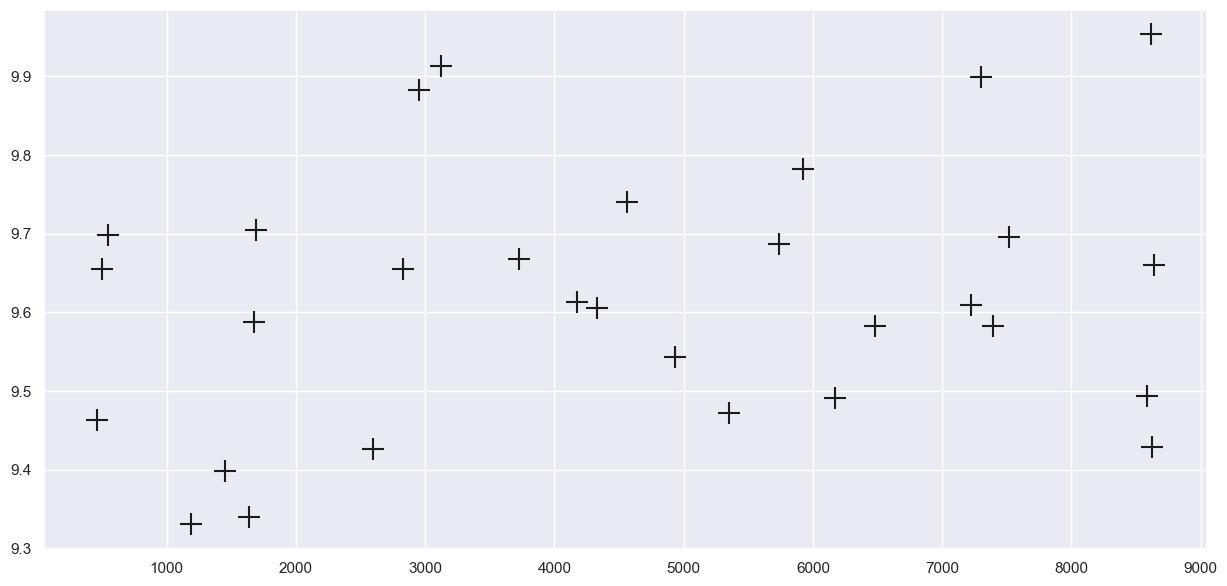

In [427]:
plt.scatter(CC[:, 0], CC[:, 1], marker = '+', s = 250, c = 'k')

In [428]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [429]:
dtc = DecisionTreeClassifier(max_depth = 10, random_state = 55)
dtc.fit(X_train, y_train)
train_score = dtc.score(X_train, y_train)
test_score = dtc.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
1.0


In [430]:
from sklearn.tree import plot_tree
cols = X.columns
cols

Index(['Patient-Uid', 'Incident', 'year', 'month', 'day', 'DayOfWeek',
       'TimeSinceLastEvent', 'Treatment_Duration', 'EventDuration',
       'TimeSinceFirstEvent', 'Frequency'],
      dtype='object')

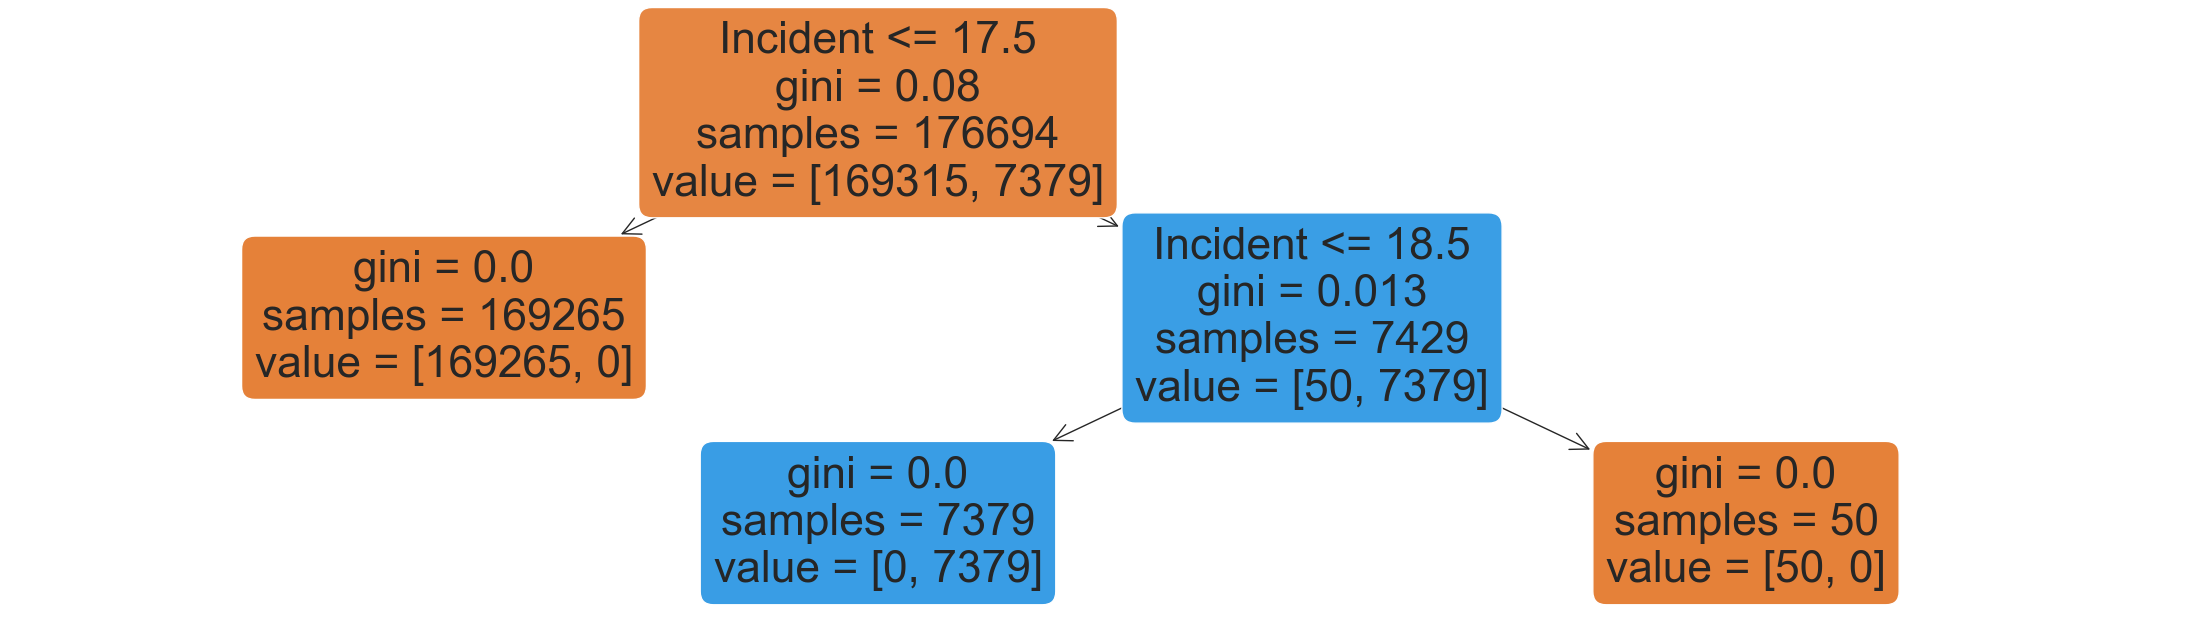

In [431]:
plt.figure(figsize=(28,8))
a = plot_tree(dtc, feature_names = cols, filled = True, rounded =True)

In [432]:
y_pred = dtc.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [433]:
y_pred.size

44174

In [434]:
dtc.feature_importances_

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [435]:
from sklearn.model_selection import cross_val_score
cross_val_score(dtc, X, y, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [437]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean() 

0.9991307034028981

In [438]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(dtc, X_train, y_train, cv = 5)
cv_scores

array([1., 1., 1., 1., 1.])

In [439]:
cv_scores.mean()

1.0

In [440]:
cv_scores.std()

0.0

In [441]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [2, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}
# gridsearchcv
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best hyperparameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [442]:
rfc = RandomForestClassifier(n_estimators = 40, max_depth =20,random_state = 3)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

1.0
1.0


In [443]:
gbc = GradientBoostingClassifier(n_estimators = 30, learning_rate = 0.1,random_state = 28)
gbc.fit(X_train, y_train)
print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

1.0
1.0


In [444]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.9582385366792308
0.9582333499343505


In [445]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
print(LR.score(X_train, y_train))
print(LR.score(X_test, y_test))

0.9997000464079142
0.9997962602435821


In [446]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=20, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.9996151582378775


In [447]:
y_pred= dtc.predict(X_test)

In [448]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix,classification_report, confusion_matrix
accuracy_score(y_test, y_pred)

1.0

In [449]:
confusion_matrix(y_test,y_pred)

array([[42329,     0],
       [    0,  1845]], dtype=int64)

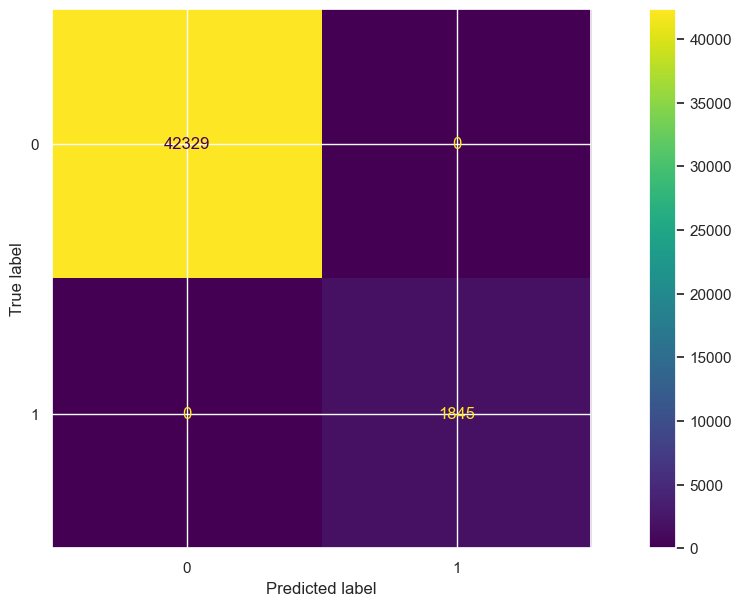

In [450]:
plot_confusion_matrix(best_model, X_test, y_test)

In [451]:
print(f1_score(y_test,y_pred, average = 'macro'))

1.0


In [452]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42329
           1       1.00      1.00      1.00      1845

    accuracy                           1.00     44174
   macro avg       1.00      1.00      1.00     44174
weighted avg       1.00      1.00      1.00     44174



In [466]:
test = pd.read_csv('test.csv', index_col = 'Unnamed: 0')
test.shape

(1065524, 3)

In [467]:
test

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0
...,...,...,...
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8


In [468]:
test.Date = pd.to_datetime(test.Date)

In [469]:
# test['target drug'] = np.where(test['Incident'].isin(['TARGET DRUG']), 1, 0)

In [470]:
test

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0
...,...,...,...
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8


In [471]:
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day
test['DayOfWeek'] = test['Date'].dt.dayofweek

In [472]:
test['Frequency'] = frequency_dist_df
test['TimeSinceLastEvent'] = test.groupby('Patient-Uid')['Date'].diff().dt.days
test['Treatment_Duration'] = (test['year'] - test['year'].min()) * 12 + test['month']
test['EventDuration'] = test.groupby('Patient-Uid')['Date'].diff().dt.days
test['TimeSinceFirstEvent'] = (test['Date'] - test.groupby('Patient-Uid')['Date'].transform('min')).dt.days

In [473]:
test = test.drop(['Date'], axis=1)

In [474]:
SI = SimpleImputer(strategy = 'constant', missing_values = np.nan)
test['TimeSinceLastEvent'] = SI.fit_transform(test[['TimeSinceLastEvent']])
test['EventDuration'] = SI.fit_transform(test[['EventDuration']])
test['Frequency'] = SI.fit_transform(test[['Frequency']])

In [475]:
OE = OrdinalEncoder()
test['Patient-Uid'] = OE.fit_transform(test[['Patient-Uid']])
test.Incident = OE.fit_transform(test[['Incident']])

In [476]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065524 entries, 0 to 1372859
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Patient-Uid          1065524 non-null  float64
 1   Incident             1065524 non-null  float64
 2   year                 1065524 non-null  int64  
 3   month                1065524 non-null  int64  
 4   day                  1065524 non-null  int64  
 5   DayOfWeek            1065524 non-null  int64  
 6   Frequency            1065524 non-null  float64
 7   TimeSinceLastEvent   1065524 non-null  float64
 8   Treatment_Duration   1065524 non-null  int64  
 9   EventDuration        1065524 non-null  float64
 10  TimeSinceFirstEvent  1065524 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 97.6 MB


In [477]:
output = dtc.predict(test)

In [478]:
test.to_csv('output.csv', index = True)